Loaded 10610 images
Dataset shape: X=(10610, 32, 32, 3), y_dict keys=['AQI', 'PM2.5', 'PM10', 'O3', 'CO', 'SO2', 'NO2']

Training model for AQI
Epoch 1/20
531/531 [==============================] - 14s 16ms/step - loss: 21.3052 - mae: 2.5470 - val_loss: 0.9211 - val_mae: 0.6987
Epoch 2/20
531/531 [==============================] - 7s 14ms/step - loss: 1.0424 - mae: 0.7180 - val_loss: 0.4617 - val_mae: 0.5132
Epoch 3/20
531/531 [==============================] - 7s 13ms/step - loss: 0.6512 - mae: 0.5768 - val_loss: 0.5342 - val_mae: 0.4365
Epoch 4/20
531/531 [==============================] - 7s 13ms/step - loss: 0.5248 - mae: 0.5217 - val_loss: 0.3277 - val_mae: 0.3977
Epoch 5/20
531/531 [==============================] - 7s 14ms/step - loss: 0.4027 - mae: 0.4672 - val_loss: 0.2695 - val_mae: 0.3705
Epoch 6/20
531/531 [==============================] - 7s 14ms/step - loss: 0.3583 - mae: 0.4455 - val_loss: 0.3442 - val_mae: 0.3916
Epoch 7/20
531/531 [==============================] - 7s

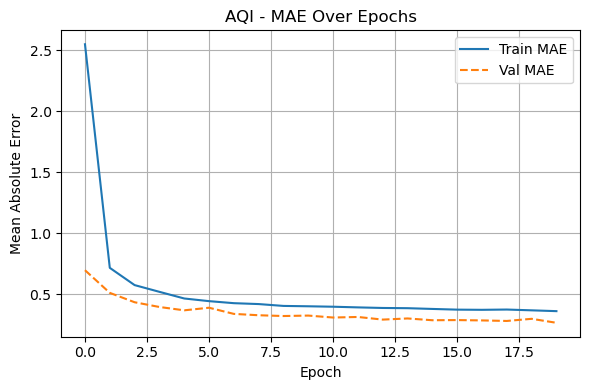

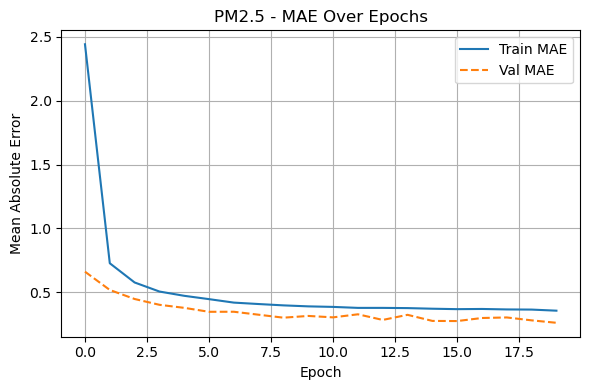

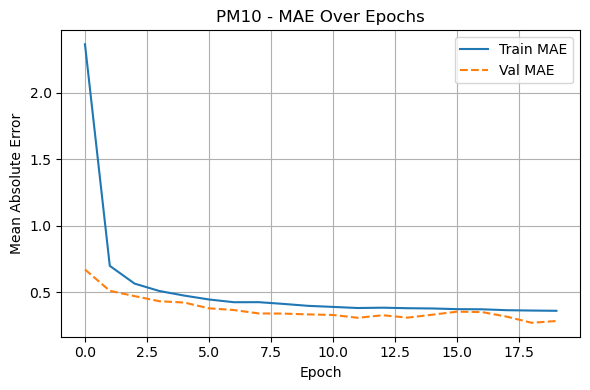

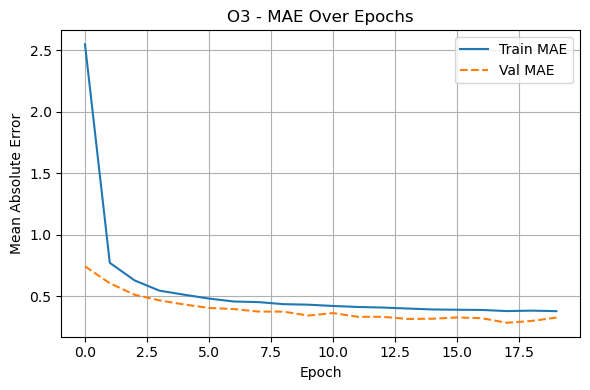

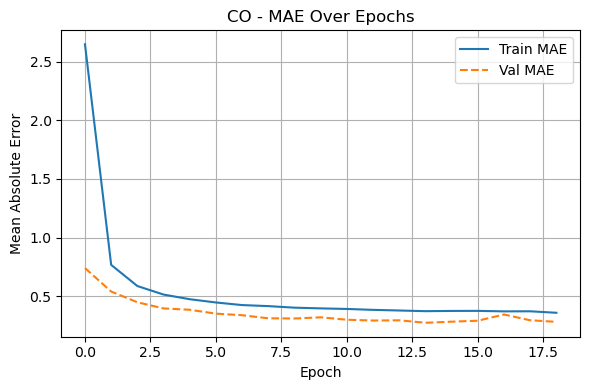

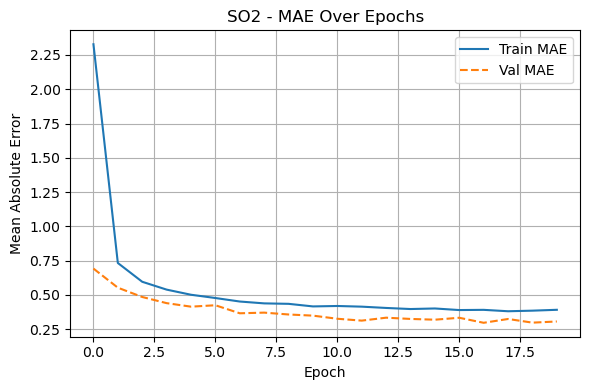

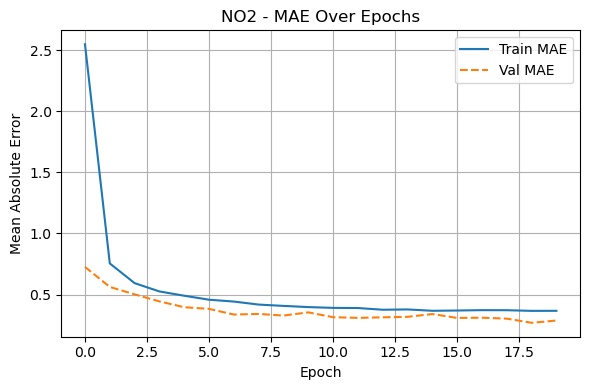


Evaluating on test data (samples: 2122)
AQI - MSE: 0.1360, MAE: 0.2684, R²: 0.8610
PM2.5 - MSE: 0.1366, MAE: 0.2608, R²: 0.8642
PM10 - MSE: 0.1641, MAE: 0.2848, R²: 0.8419
O3 - MSE: 0.1978, MAE: 0.3257, R²: 0.8075
CO - MSE: 0.1632, MAE: 0.2731, R²: 0.8359
SO2 - MSE: 0.1854, MAE: 0.3064, R²: 0.8103
NO2 - MSE: 0.1734, MAE: 0.2868, R²: 0.8268

Predicting for a new image:
Predicted AQI: 143.6402
Predicted PM2.5: 126.4513
Predicted PM10: 142.0769
Predicted O3: 122.6488
Predicted CO: 21.6100
Predicted SO2: 10.2873
Predicted NO2: 39.2163


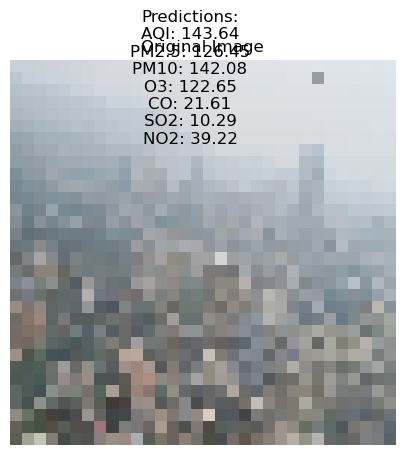

In [1]:
# Cell 1: Imports and constants
import pandas as pd
import os
import numpy as np
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from functools import lru_cache
import matplotlib.pyplot as plt

iMAGE_PIXEL = 32
BATCH_SIZE = 16

# Cell 2: Image loading functions
@lru_cache(maxsize=100000)
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image at {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return cv2.resize(img, (iMAGE_PIXEL, iMAGE_PIXEL))

def load_images_with_data(image_dir, csv_file):
    df = pd.read_csv(csv_file)
    image_data_list = []
    for _, row in df.iterrows():
        image_name = row['Filename']
        image_path = os.path.join(image_dir, image_name)
        if os.path.exists(image_path):
            try:
                img_resized = load_and_preprocess_image(image_path)
                values = row.to_dict()
                values['image'] = img_resized
                image_data_list.append(values)
            except Exception as e:
                print(f"Error loading image {image_name}: {e}")
        else:
            print(f"Warning: Image '{image_name}' not found in '{image_dir}'.")
    return image_data_list

# Load data
image_dir = "F:/Pheonix/Thesis/Project/Code/AQI Index/.venv/Dev/Data/cleaned_folder"
csv_file = "F:/Pheonix/Thesis/Project/Code/AQI Index/.venv/Dev/Data/cleaned_data.csv"
image_data_list = load_images_with_data(image_dir, csv_file)
print(f"Loaded {len(image_data_list)} images")

# Cell 3: Dataset preparation with normalization
def prepare_dataset(image_data_list):
    X = []
    y_dict = {'AQI': [], 'PM2.5': [], 'PM10': [], 'O3': [], 'CO': [], 'SO2': [], 'NO2': []}
    for data in image_data_list:
        img = preprocess_input(data['image'])
        X.append(img)
        for param in y_dict:
            y_dict[param].append(data[param])
    X = np.array(X)
    
    scaler_dict = {}
    for key in y_dict:
        scaler = StandardScaler()
        y_scaled = scaler.fit_transform(np.array(y_dict[key]).reshape(-1, 1)).flatten()
        y_dict[key] = y_scaled
        scaler_dict[key] = scaler
    return X, y_dict, scaler_dict

X, y_dict, scaler_dict = prepare_dataset(image_data_list)
print(f"Dataset shape: X={X.shape}, y_dict keys={list(y_dict.keys())}")

# Cell 4: VGG16 transfer learning model
def build_transfer_model(input_shape=(iMAGE_PIXEL, iMAGE_PIXEL, 3)):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1)(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Cell 5: Training function
def train_models(X, y_dict):
    models = {}
    histories = {}
    
    for param, y_values in y_dict.items():
        print(f"\nTraining model for {param}")
        X_train, X_test, y_train, y_test = train_test_split(X, y_values, test_size=0.2, random_state=42)
        model = build_transfer_model()
        
       # callbacks = [
       #     EarlyStopping(patience=5, restore_best_weights=True),
       #     ModelCheckpoint(f"best_model_{param}.h5", save_best_only=True)
       # ]
        callbacks = [EarlyStopping(patience=5, restore_best_weights=True)]
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                            epochs=20, batch_size=BATCH_SIZE, verbose=1,
                            callbacks=callbacks)
        models[param] = model
        histories[param] = history
    return models, histories

# Train models
models, histories = train_models(X, y_dict)

# Cell 6: Plot MAE for each parameter
for param, history in histories.items():
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE', linestyle='--')
    plt.title(f'{param} - MAE Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Cell 7: Evaluation
def test_model(models, scaler_dict, X_test=None, y_test_dict=None, new_image_path=None):
    results = {}
    
    if X_test is not None and y_test_dict is not None:
        print(f"\nEvaluating on test data (samples: {X_test.shape[0]})")
        for param, model in models.items():
            test_loss, test_mae = model.evaluate(X_test, y_test_dict[param], verbose=0)
            y_pred_scaled = model.predict(X_test, verbose=0).flatten()
            y_true_scaled = y_test_dict[param]
            r2 = r2_score(y_true_scaled, y_pred_scaled)

            # Inverse scale for readability
            y_pred = scaler_dict[param].inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
            y_true = scaler_dict[param].inverse_transform(y_true_scaled.reshape(-1, 1)).flatten()

            print(f"{param} - MSE: {test_loss:.4f}, MAE: {test_mae:.4f}, R²: {r2:.4f}")
            results[param] = {
                'MSE': test_loss, 'MAE': test_mae, 'R²': r2,
                'y_true': y_true, 'y_pred': y_pred
            }
    
    elif new_image_path is not None:
        print("\nPredicting for a new image:")
        img_resized = load_and_preprocess_image(new_image_path)
        img_processed = preprocess_input(img_resized)
        img_processed = np.expand_dims(img_processed, axis=0)
        
        for param, model in models.items():
            pred_scaled = model.predict(img_processed, verbose=0)[0][0]
            pred = scaler_dict[param].inverse_transform([[pred_scaled]])[0][0]
            results[param] = pred
            print(f"Predicted {param}: {pred:.4f}")
    else:
        raise ValueError("Provide either test data or new_image_path")
    return results

# Cell 8: Evaluate on test data
X_train, X_test, y_train_dict, y_test_dict = {}, {}, {}, {}
for param, y_values in y_dict.items():
    X_train[param], X_test[param], y_train_dict[param], y_test_dict[param] = train_test_split(
        X, y_values, test_size=0.2, random_state=42
    )

test_results = test_model(models, scaler_dict, X_test['AQI'], y_test_dict)

# Cell 9: Predict new image
new_image_path = "F:/Pheonix/Thesis/Project/Code/AQI Index/.venv/Dev/Data/cleaned_folder/MH_UnFSG_2023-03-14-13.00-1-343.jpg"
pred_results = test_model(models, scaler_dict, new_image_path=new_image_path)

# Cell 10: Display prediction
img = load_and_preprocess_image(new_image_path)
plt.figure(figsize=(10, 5))
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')
plt.suptitle("Predictions:\n" + "\n".join(f"{param}: {value:.2f}" for param, value in pred_results.items()))
plt.show()
